## Dependency installation and data downloading and unpacking

In [1]:
# Install dependencies
!python -m pip install spacy pandas numpy seaborn matplotlib scikit-learn dask pyarrow

# For lemmatization, make sure spaCy is installed along with its english module
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 5.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Download and extract the dataset for NLP with Disaster Tweets Kaggle competition
# !kaggle competitions download -c nlp-getting-started
!unzip nlp-getting-started.zip -d nlp-getting-started

## Load / Reload project
This section just resets the dataframe to its original state

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
# Load the datasets
og_train_df = pd.read_csv("nlp-getting-started/train.csv")
og_test_df = pd.read_csv("nlp-getting-started/test.csv")

In [5]:
og_train_df["id"].value_counts().sum()
og_test_df["id"].value_counts().sum()

np.int64(3263)

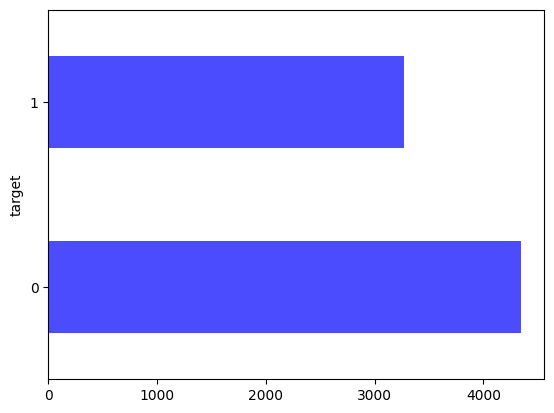

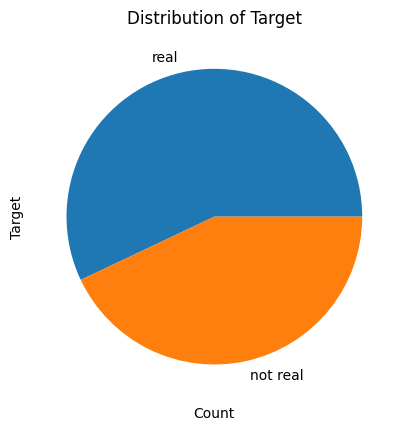

In [6]:
og_train_df["target"].value_counts().plot(kind='barh', color='blue', alpha=0.7)
plt.show()

plt.pie(og_train_df["target"].value_counts(), labels=["real", "not real"])
plt.xlabel("Count")
plt.ylabel("Target")
plt.title("Distribution of Target")
plt.show()

## Preprocessing

Preprocess the dataset before splitting it into the 70/30 distribution required by the assignment. Although we have followed the instruction's recommendations. We took some liberties with the order and depth to which we followed the instructions. Thus, our preprocesing consists of:

1. Removing punctuation  - This is helpful in standardizing the texts, but can create some isues in multiword lexical units and names. To solve this, a name entity recognition should be applied before this step.

2. Converting all text to lower case - As with the previous point, this help in standardization. Makes the text uniform and minimizes the influence of grammatical errors or stylized text.

3. Stopword removal - Stopwords are lexical units that have no semantic meaning; they are present to satisfy the syntactic requirements of the language. Thus, they are of little to no use to us in this assignment. The list of stopwords used in this program was provided on [this website](https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt)

4. Lemmatization - This helps the system identify all lexemes of a lexical unit as a single lexical unit. Avoids redundant storage missuse and improves accuracy. For this step, due to implementational advantages brought by spaCy, spaCy was used instead of NLTK as the assignment description reccommended. 

5. Handling null values - This dataset contains some null values in some columns, thus we used the `pandas.fillna()` method to fill these spots. Text columns with an `NoValue` string, and numeric columns with a Zero value.

6. Training dataset 70/30 split - Since our test dataset does not contain the target values we aim to predict, we must use a subset of our training set for the purposes of fine-tuning the model. Another option to consider would be running a k-fold structure.

In [7]:
# Remove punctuation to allow for better word manipulation, except in hyphenation cases, an exception we're willing to make given that this is not a deep linguistic analisys. However, if we wanted to maintain the most semantic context, a name entity recognition system should parse this text beforehand.
import string

print(og_train_df['text'].head())

# Remove punctuation using translate
og_train_df["text"] = og_train_df["text"].str.translate(str.maketrans("", "", string.punctuation))
og_train_df['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object


0    Our Deeds are the Reason of this earthquake Ma...
1                Forest fire near La Ronge Sask Canada
2    All residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    Just got sent this photo from Ruby Alaska as s...
Name: text, dtype: object

In [8]:
# Convert text to lowercase
og_train_df['text'] = og_train_df['text'].str.lower()
og_train_df["text"].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [9]:
# Get the list of stopwords to be removed (stopwords list not mine)
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 

# This function takes a string and checks if each of its words is in the stopword list. If so, it removes it from the string
def remove_stopwords(text):
    if isinstance(text, str):  # Ensure the value is a string
        return " ".join([word for word in text.split() if word not in stopwords])
    return text

og_train_df['text'] = og_train_df['text'].apply(remove_stopwords)

print(og_train_df["text"].head())

0                deeds reason earthquake allah forgive
1                             forest ronge sask canada
2    residents asked shelter place notified officer...
3    13000 people receive wildfires evacuation orde...
4       photo ruby alaska smoke wildfires pours school
Name: text, dtype: object


In [9]:
# Lemmatize the remaining words
import spacy

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Function to lemmatize text
def lemmatize_text(text):
    if isinstance(text, str):  # Ensure input is a string
        return " ".join([token.lemma_ for token in nlp(text)])
    return text

# Apply to a specific column
og_train_df['text'] = og_train_df['text'].apply(lemmatize_text)

print(og_train_df['text'])

0       our deed be the reason of this earthquake may ...
1                   forest fire near la ronge sask canada
2       all resident ask to shelter in place be be not...
3       13000 people receive wildfire evacuation order...
4       just get send this photo from ruby alaska as s...
                              ...                        
7608    two giant crane hold a bridge collapse into ne...
7609    ariaahrary thetawniest the out of control wild...
7610    m194 0104 utc5 km s of volcano hawaii httptcoz...
7611    police investigate after an ebike collide with...
7612    the late more home raze by northern california...
Name: text, Length: 7613, dtype: object


In [10]:
# Replace NaNs on numerical columns
og_train_df[['keyword', 'location', 'text']] = og_train_df[['keyword', 'location', 'text']].fillna("NoValue")
og_train_df['target'] = og_train_df['target'].fillna(0)

In [11]:
from sklearn.model_selection import train_test_split

# Split DataFrame into 70% train and 30% test
train_df, test_df = train_test_split(og_train_df, test_size=0.3, random_state=42)
train_df.head()

,id,keyword,location,text,target
1186,1707,bridge%20collapse,NoValue,ashe 2015 australiaûªs collapse at trent brid...,0
4071,5789,hail,"Carol Stream, Illinois",great michigan technique camp \n b1 g thank to...,1
5461,7789,police,Houston,cnn tennessee movie theater shooting suspect k...,1
5787,8257,rioting,NoValue,still riot in a couple of hour leave until I h...,1
7445,10656,wounds,Lake Highlands,crack in the path where I wipe out this mornin...,0


In [12]:
test_df.head()

,id,keyword,location,text,target
2644,3796,destruction,NoValue,so you have a new weapon that can cause unimag...,1
2227,3185,deluge,NoValue,the fampe thing I do for gishwhe just get soak...,0
5448,7769,police,UK,dt georgegalloway rt galloway4mayor ûïthe col...,1
132,191,aftershock,NoValue,aftershock back to school kick off be great I ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma child of addict develop ...,0


## Bag of Word -ing

As a first step towards making a bag of words, the words that each vector will contain must be chose. While we could use all of the words, this might be too computationally intensive. Furthermore, words with low apparitions would not add much to the model. Thus we do the following:

1. Count how many times each word appears

2. Analyze the correlation between words and target

3. Choose those words with the most appearances and highest correlation to target

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# Use CountVectorizer to tokenize and extract unique words
vectorizer = CountVectorizer()
vectorizer.fit(train_df["text"])  # Fit to the text column

# Get the number of unique words in the original dataframe
print(f"Total unique words: {len(vectorizer.get_feature_names_out())}")

Total unique words: 15658


### Correlation Analysis

In [14]:
M = 22 # How many tweets the word must appear in to be considered as one of the K words
K = 400 # Words the vector will have

vectorizer = CountVectorizer(
    binary=True,    # Treat a word as either present or not present
    min_df=M,       # Ignore words that do not appear in at least M Tweets
    max_features=K, # Maximum size of the final vocabulary vector
    stop_words="english",   # Remove any straggling stop-words
    # ngram_range=(1,2)       # include unigrams and bigrams
    )
X_words = vectorizer.fit_transform(train_df["text"]).toarray()

# Convert to DataFrame
word_df = pd.DataFrame(X_words, columns=vectorizer.get_feature_names_out())

# Add target variable
word_df["target"] = train_df["target"]

# Get the number of unique words in the vector given our current K and M
print(f"Total unique words: {len(vectorizer.get_feature_names_out())}")

Total unique words: 387


In [15]:
# Compute correlation with target for each word
correlations = word_df.corr()["target"].drop("target")  # Exclude target itself

In [16]:
# Extract word feature names
word_names = vectorizer.get_feature_names_out()

# Count how many rows each word appears in (document frequency)
word_counts = word_df.iloc[:, :-1].sum(axis=0).values  # Sum across rows

# Ensure that word_names, word_counts, and correlations are the same length
min_length = min(len(word_names), len(word_counts), len(correlations))

word_names = word_names[:min_length]
word_counts = word_counts[:min_length]
correlations = correlations.values[:min_length]

# Create DataFrame with word stats
word_stats = pd.DataFrame({
    "word": word_names,
    "rows_appeared": word_counts,
    "correlation": correlations
})

# Take absolute values of correlations for ranking purposes
word_stats["correlation"] = word_stats["correlation"].abs()

# Select top 30 words based on appearance count**
word_stats = word_stats.sort_values(by="rows_appeared", ascending=False).head(50)

# Sort by absolute correlation and show the top words
top_words_by_correlation = word_stats.sort_values(by="correlation", ascending=False).head()

# Display the results
top_words_by_correlation


,word,rows_appeared,correlation
48,california,84,0.042320
35,body,105,0.041421
66,come,112,0.030130
280,say,142,0.030056
202,love,76,0.027368


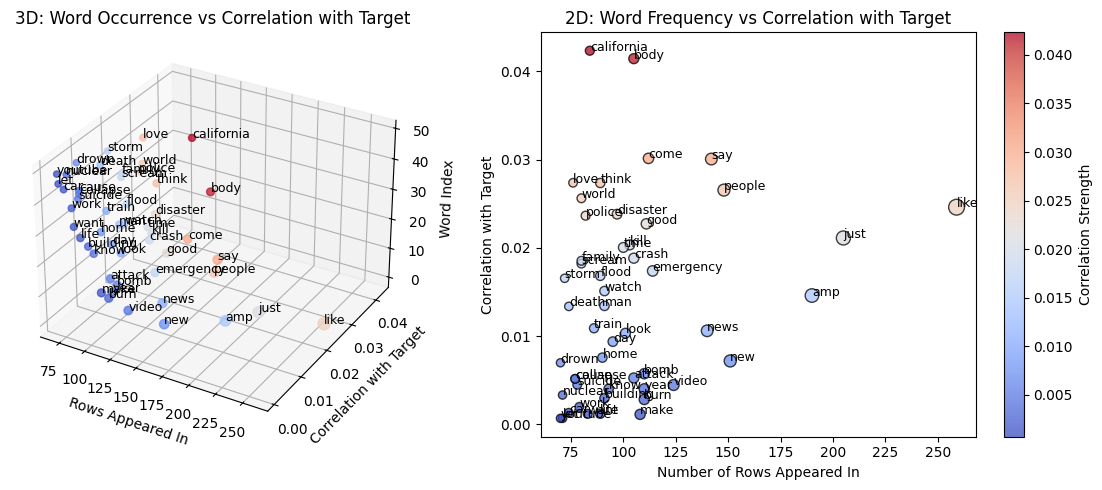

In [17]:
# Create a figure with two subplots
fig = plt.figure(figsize=(12, 5))

# -------- 3D Scatter Plot (Left Side) -------- #
ax1 = fig.add_subplot(121, projection="3d")

sc1 = ax1.scatter(
    word_stats["rows_appeared"],  # X-axis
    word_stats["correlation"],  # Y-axis
    range(len(word_stats)),  # Z-axis (just for spacing)
    s=word_stats["rows_appeared"] * 0.3,  # Bubble size
    c=word_stats["correlation"],  # Color based on correlation
    cmap="coolwarm",
    alpha=0.75
)

# Add word labels at select points
for i, word in enumerate(word_stats["word"]):
    ax1.text(word_stats["rows_appeared"].iloc[i], 
             word_stats["correlation"].iloc[i], 
             i, word, fontsize=9)

# Labels
ax1.set_xlabel("Rows Appeared In")
ax1.set_ylabel("Correlation with Target")
ax1.set_zlabel("Word Index")
ax1.set_title("3D: Word Occurrence vs Correlation with Target")

# -------- 2D Scatter Plot (Right Side) -------- #
ax2 = fig.add_subplot(122)

sc2 = ax2.scatter(
    word_stats["rows_appeared"], 
    word_stats["correlation"], 
    s=word_stats["rows_appeared"] * 0.5,  # Bubble size
    c=word_stats["correlation"],  # Color based on correlation
    cmap="coolwarm",
    alpha=0.75,
    edgecolors="k"
)

# Add labels to selected points
for i, word in enumerate(word_stats["word"]):
    ax2.annotate(word, 
                 (word_stats["rows_appeared"].iloc[i], word_stats["correlation"].iloc[i]), 
                 fontsize=9)

# Labels
ax2.set_xlabel("Number of Rows Appeared In")
ax2.set_ylabel("Correlation with Target")
ax2.set_title("2D: Word Frequency vs Correlation with Target")

# Add colorbar for better interpretation
cbar = fig.colorbar(sc2, ax=ax2)
cbar.set_label("Correlation Strength")

# Show both plots
plt.tight_layout()
plt.show()


## Logistic Regresion

In this question, we will be training logistic regression models using bag of words feature vectors obtained in part (d). We will use the F1-score as the evaluation metric.

### No regularization

Train a logistic regression model without regularization terms. You will notice that the default sklearn logistic regression utilizes L2 regularization. You can turn off L2 regularization by changing the penalty parameter. Report the F1 score in your training and development set. Comment on whether you observe any issues with over-fitting or under-fitting.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Get the training data for each df
X_train_words = vectorizer.fit_transform(train_df['text'])
X_dev_words = vectorizer.transform(test_df['text'])

# Initialize logistic regression without regularization
logreg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)

# Train (fit) on training data
logreg.fit(X_train_words, train_df["target"])

# Predict on training and development sets
y_train_pred = logreg.predict(X_train_words)
y_dev_pred = logreg.predict(X_dev_words)

# Compute F1 scores
f1_train = f1_score(train_df["target"], y_train_pred)
f1_dev = f1_score(test_df["target"], y_dev_pred)

print(f"F1 Score (Training Set): {f1_train:.4f}")
print(f"F1 Score (Development Set): {f1_dev:.4f}")
print(f"Difference: {(f1_train - f1_dev):.4f}")

# Print the most relevant word to target
print(vectorizer.get_feature_names_out()[np.argmax(logreg.coef_)])

F1 Score (Training Set): 0.7568
F1 Score (Development Set): 0.6961
Difference: 0.0607
derailment


### L1 Regularization

Train a logistic regression model with L1 regularization. Sklearn provides some good examples for implementation. Report the performance on both the training and the development sets.

In [19]:
# Initialize logistic regression without regularization
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Train (fit) on training data
logreg.fit(X_train_words, train_df["target"])

# Predict on training and development sets
y_train_pred = logreg.predict(X_train_words)
y_dev_pred = logreg.predict(X_dev_words)

# Compute F1 scores
f1_train = f1_score(train_df["target"], y_train_pred)
f1_dev = f1_score(test_df["target"], y_dev_pred)

print(f"F1 Score (Training Set): {f1_train:.4f}")
print(f"F1 Score (Development Set): {f1_dev:.4f}")
print(f"Difference: {(f1_train - f1_dev):.4f}")

# Print the most relevant word to target
print(vectorizer.get_feature_names_out()[np.argmax(logreg.coef_)])

F1 Score (Training Set): 0.7507
F1 Score (Development Set): 0.6978
Difference: 0.0530
spill


### L2 Regularization

Similarly, train a logistic regression model with L2 regularization. Report the performance on the training and the development sets.

In [21]:
# Initialize logistic regression without regularization
logreg = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)

# Train (fit) on training data
logreg.fit(X_train_words, train_df["target"])

# Predict on training and development sets
y_train_pred = logreg.predict(X_train_words)
y_dev_pred = logreg.predict(X_dev_words)

# Compute F1 scores
f1_train = f1_score(train_df["target"], y_train_pred)
f1_dev = f1_score(test_df["target"], y_dev_pred)

print(f"F1 Score (Training Set): {f1_train:.4f}")
print(f"F1 Score (Development Set): {f1_dev:.4f}")
print(f"Difference: {(f1_train - f1_dev):.4f}")

# Print the most relevant word to target
print(vectorizer.get_feature_names_out()[np.argmax(logreg.coef_)])

F1 Score (Training Set): 0.7451
F1 Score (Development Set): 0.6899
Difference: 0.0552
hiroshima


## Bernoulli Naive Bayes

Implement a Bernoulli Naive Bayes classifier to predict the probability of whether each tweet is about a real disaster. Train this classifier on the training set, and report its F1-score on the development set.

Important: For this question you should implement the classifier yourself similar to what was shown in class, without using any existing machine learning libraries such as sklearn. You may only use basic libraries such as numpy. As you work on this problem, you may find that some words in the vocabulary occur in the development set but are not in the training set. As a result, the standard Naive Bayes model learns to assign them an occurrence probability of zero, which becomes problematic when we observe this “zero probability” event on our development set.

The solution to this problem is a form of regularization called Laplace smoothing or additive smoothing. The idea is to use “pseudo-counts,” i.e., to increment the number of times we have seen each word or document by some number of “virtual” occurrences $\alpha$. Thus, the Naive Bayes model will behave as if every word or document has been seen at least $\alpha$ times.

More formally, the $\psi_{jk}$ parameter of Bernoulli Naive Bayes is the probability of observing word j within class k. Its normal maximum likelihood estimate is: $$\psi_{jk} = \frac{n_{jk}}{n_k}$$ where $n_k$ is the number of documents of class $k$ and $n_{jk}$ is the number of documents of class $k$ that contain word $j$. In Laplace smoothing, we increment each counter $n_{jk}$ by $\alpha$ (thus we count each word an extra $\alpha$ times), and the resulting estimate for $\psi_{jk}$ becomes: $$\psi_{jk} = \frac{n_{jk}+\alpha}{n_k+2\alpha}$$

 It’s normal to take $\alpha = 1$.

### Convert bag of words into df for better readability

In [22]:
word_df = pd.DataFrame(X_train_words.toarray(), columns=vectorizer.get_feature_names_out())
word_df["target"] = train_df["target"].values  # Ensure it's a NumPy array to align correctly

In [23]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

class BernoulliNaiveBayes:
    def __init__(self, alpha=1, M=22, K=400):
        self.alpha = alpha  # Smoothing parameter
        self.M = M # The number of tweets a word must appear in to be considered
        self.K = K # The max number of words in the bag of words vector
        self.vectorizer = None  # CountVectorizer will be initialized during fitting
        self.class_probs = {}  # P(y) for each class
        self.word_probs = {}  # P(x_j | y) probabilities
    
    def fit(self, df):
        """
        Fits the Bernoulli Naive Bayes model on the given DataFrame.
        The DataFrame must have 'text' and 'target' columns.
        """
        # Step 1: Convert text into a binary bag-of-words representation
        self.vectorizer = vectorizer = CountVectorizer(
            binary=True,    # Treat a word as either present or not present
            min_df=M,       # Ignore words that do not appear in at least M Tweets
            max_features=K, # Maximum size of the final vocabulary vector
            stop_words="english",   # Remove any straggling stop-words
            ngram_range=(1,2)       # include unigrams and bigrams
            )
        X_words = self.vectorizer.fit_transform(df["text"]).toarray()  # Convert to numpy array
        y = df["target"].values  # Extract target labels
        
        # Step 2: Split into two groups based on class labels
        X1 = X_words[y == 1]  # Tweets labeled as real disasters
        X0 = X_words[y == 0]  # Tweets labeled as not real disasters
        
        # Step 3: Compute P(y) (prior probability of each class)
        self.class_probs[1] = len(X1) / len(y)  # P(y=1)
        self.class_probs[0] = len(X0) / len(y)  # P(y=0)
        
        # Step 4: Compute P(x_j | y) for each word (word probabilities with Laplace smoothing)
        word_counts_1 = np.sum(X1, axis=0)  # Count word occurrences in class 1
        word_counts_0 = np.sum(X0, axis=0)  # Count word occurrences in class 0
        
        total_words_1 = X1.shape[0]  # Total number of samples in class 1
        total_words_0 = X0.shape[0]  # Total number of samples in class 0
        
        self.word_probs[1] = (word_counts_1 + self.alpha) / (total_words_1 + 2 * self.alpha)
        self.word_probs[0] = (word_counts_0 + self.alpha) / (total_words_0 + 2 * self.alpha)
    
    def predict(self, df):
        """
        Predicts class labels for a given DataFrame with 'text' column.
        """
        X_words = self.vectorizer.transform(df["text"]).toarray()  # Convert text to binary bag-of-words
        log_prob_1 = np.log(self.class_probs[1]) + np.sum(np.log(self.word_probs[1]) * X_words, axis=1)
        log_prob_0 = np.log(self.class_probs[0]) + np.sum(np.log(self.word_probs[0]) * X_words, axis=1)
        
        return (log_prob_1 > log_prob_0).astype(int)  # Return class with higher log-probability
    
    def evaluate(self, df):
        """
        Computes the F1 score on a given dataset.
        """
        y_true = df["target"].values  # Extract true labels
        y_pred = self.predict(df)  # Predict labels
        return f1_score(y_true, y_pred)



### Train and Evaluate using BNB

In [24]:
# Train the model
bnb = BernoulliNaiveBayes(alpha=1, M=10, K=1200)
bnb.fit(train_df)  # Automatically handles vectorization & probability calculations

# Evaluate on training and dev sets
f1_train = bnb.evaluate(train_df)
f1_dev = bnb.evaluate(test_df)

# Print results
print(f"F1 Score (Training Set): {f1_train:.4f}")
print(f"F1 Score (Development Set): {f1_dev:.4f}")
print(f"Difference (Train - Dev): {f1_train - f1_dev:.4f}")


F1 Score (Training Set): 0.7388
F1 Score (Development Set): 0.7049
Difference (Train - Dev): 0.0340


## N-Grams

The N-gram model is similar to the bag of words model, but instead of using individual words we use N-grams, which are contiguous sequences of words. For example, using $N = 2$, we would say that the text “Alice fell down the rabbit hole” consists of the sequence of 2-grams: [“Alice fell”, “fell down”, “down the”, “the rabbit”, “rabbit hole”], and the following sequence of 1-grams: [“Alice”, “fell”, “down”, “the”, “rabbit”, “hole”]. All eleven of these symbols may be included in the vocabulary, and the feature vector x is defined according to $x_i = 1$ if the i’th vocabulary symbol occurs in the tweet, and $x_i = 0$ otherwise. Using $N = 2$, construct feature representations of the tweets in the training and development tweets. Again, you should choose a threshold M, and only include symbols in the vocabulary that occur in at least M different tweets in the training set. 
- Discuss how you chose the threshold M, and 
- report the total number of 1-grams and 2-grams in your vocabulary. In addition, 
- take 10 2-grams from your vocabulary, and print them out.

Then, implement a logistic regression and a Bernoulli classifier to train on 2-grams. You may reuse the code in (e) and (f). You may also choose to use or not use a regularization term, depending on what you got from (e). Report your results on training and development sets. Do these results differ significantly from those using the bag of words model? Discuss what this implies about the task.

Again, we suggest using CountVectorizer to construct these features. In order to include both 1-gram and 2-gram features, you can set ngram_range=(1,2).

Note also that in this case, since there are probably many different 2-grams in the dataset, it is especially important carefully set min_df in order to avoid run-time and memory issues.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# Use CountVectorizer to tokenize and extract unique words
vectorizer = CountVectorizer()
vectorizer.fit(train_df["text"])  # Fit to the text column

# Get the number of unique words in the original dataframe
print(f"Total unique words: {len(vectorizer.get_feature_names_out())}")

Total unique words: 15335


### Correlation Analysis

In [26]:
M = 22 # How many tweets the word must appear in to be considered as one of the K words
K = 400 # Words the vector will have

vectorizer = CountVectorizer(
    binary=True,    # Treat a word as either present or not present
    min_df=M,       # Ignore words that do not appear in at least M Tweets
    max_features=K, # Maximum size of the final vocabulary vector
    stop_words="english",   # Remove any straggling stop-words
    ngram_range=(1,2)       # include unigrams and bigrams
    )
X_words = vectorizer.fit_transform(train_df["text"]).toarray()

# Convert to DataFrame
word_df = pd.DataFrame(X_words, columns=vectorizer.get_feature_names_out())

# Add target variable
word_df["target"] = train_df["target"]

# Get the number of unique words in the vector given our current K and M
print(f"Total unique words: {len(vectorizer.get_feature_names_out())}")

Total unique words: 351


In [27]:
# Compute correlation with target for each word
correlations = word_df.corr()["target"].drop("target")  # Exclude target itself

In [28]:
# Extract word feature names
word_names = vectorizer.get_feature_names_out()

# Count how many rows each word appears in (document frequency)
word_counts = word_df.iloc[:, :-1].sum(axis=0).values  # Sum across rows

# Ensure that word_names, word_counts, and correlations are the same length
min_length = min(len(word_names), len(word_counts), len(correlations))

word_names = word_names[:min_length]
word_counts = word_counts[:min_length]
correlations = correlations.values[:min_length]

# Create DataFrame with word stats
word_stats = pd.DataFrame({
    "word": word_names,
    "rows_appeared": word_counts,
    "correlation": correlations
})

# Take absolute values of correlations for ranking purposes
word_stats["correlation"] = word_stats["correlation"].abs()

# Select top 30 words based on appearance count**
word_stats = word_stats.sort_values(by="rows_appeared", ascending=False).head(50)

# Sort by absolute correlation and show the top words
top_words_by_correlation = word_stats.sort_values(by="correlation", ascending=False).head()

# Display the results
top_words_by_correlation


,word,rows_appeared,correlation
47,california,84,0.042320
33,body,105,0.041421
117,feel,66,0.036223
191,love,75,0.030336
149,hiroshima,68,0.026824


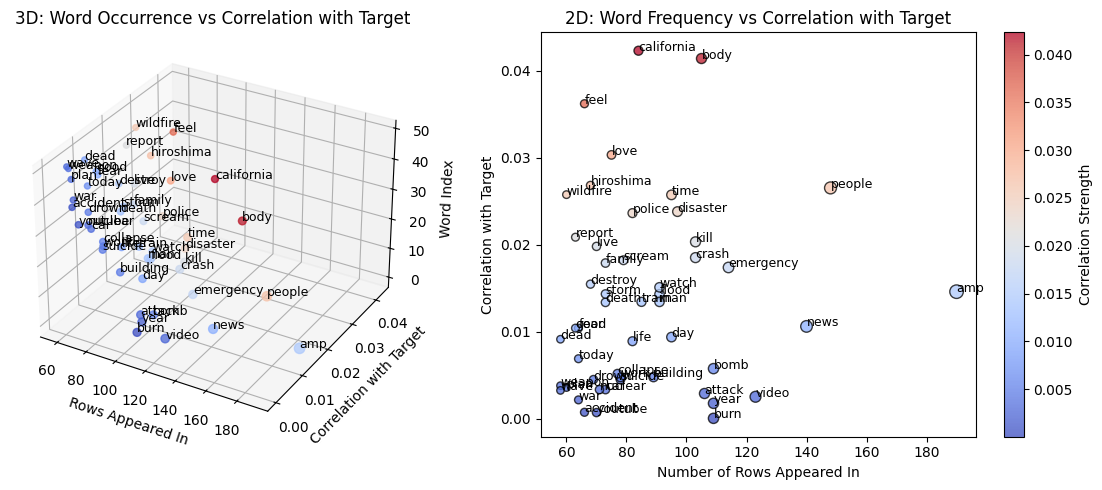

In [29]:
# Create a figure with two subplots
fig = plt.figure(figsize=(12, 5))

# -------- 3D Scatter Plot (Left Side) -------- #
ax1 = fig.add_subplot(121, projection="3d")

sc1 = ax1.scatter(
    word_stats["rows_appeared"],  # X-axis
    word_stats["correlation"],  # Y-axis
    range(len(word_stats)),  # Z-axis (just for spacing)
    s=word_stats["rows_appeared"] * 0.3,  # Bubble size
    c=word_stats["correlation"],  # Color based on correlation
    cmap="coolwarm",
    alpha=0.75
)

# Add word labels at select points
for i, word in enumerate(word_stats["word"]):
    ax1.text(word_stats["rows_appeared"].iloc[i], 
             word_stats["correlation"].iloc[i], 
             i, word, fontsize=9)

# Labels
ax1.set_xlabel("Rows Appeared In")
ax1.set_ylabel("Correlation with Target")
ax1.set_zlabel("Word Index")
ax1.set_title("3D: Word Occurrence vs Correlation with Target")

# -------- 2D Scatter Plot (Right Side) -------- #
ax2 = fig.add_subplot(122)

sc2 = ax2.scatter(
    word_stats["rows_appeared"], 
    word_stats["correlation"], 
    s=word_stats["rows_appeared"] * 0.5,  # Bubble size
    c=word_stats["correlation"],  # Color based on correlation
    cmap="coolwarm",
    alpha=0.75,
    edgecolors="k"
)

# Add labels to selected points
for i, word in enumerate(word_stats["word"]):
    ax2.annotate(word, 
                 (word_stats["rows_appeared"].iloc[i], word_stats["correlation"].iloc[i]), 
                 fontsize=9)

# Labels
ax2.set_xlabel("Number of Rows Appeared In")
ax2.set_ylabel("Correlation with Target")
ax2.set_title("2D: Word Frequency vs Correlation with Target")

# Add colorbar for better interpretation
cbar = fig.colorbar(sc2, ax=ax2)
cbar.set_label("Correlation Strength")

# Show both plots
plt.tight_layout()
plt.show()


### Logistic Regresion for N-grams

### No regularization

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Get the training data for each df
X_train_words = vectorizer.fit_transform(train_df['text'])
X_dev_words = vectorizer.transform(test_df['text'])

# Initialize logistic regression without regularization
logreg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)

# Train (fit) on training data
logreg.fit(X_train_words, train_df["target"])

# Predict on training and development sets
y_train_pred = logreg.predict(X_train_words)
y_dev_pred = logreg.predict(X_dev_words)

# Compute F1 scores
f1_train = f1_score(train_df["target"], y_train_pred)
f1_dev = f1_score(test_df["target"], y_dev_pred)

print(f"F1 Score (Training Set): {f1_train:.4f}")
print(f"F1 Score (Development Set): {f1_dev:.4f}")
print(f"Difference: {(f1_train - f1_dev):.4f}")

# Print the most relevant word to target
print(vectorizer.get_feature_names_out()[np.argmax(logreg.coef_)])

F1 Score (Training Set): 0.7519
F1 Score (Development Set): 0.6862
Difference: 0.0657
derailment


### L1 Regularization

In [31]:
# Initialize logistic regression without regularization
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Train (fit) on training data
logreg.fit(X_train_words, train_df["target"])

# Predict on training and development sets
y_train_pred = logreg.predict(X_train_words)
y_dev_pred = logreg.predict(X_dev_words)

# Compute F1 scores
f1_train = f1_score(train_df["target"], y_train_pred)
f1_dev = f1_score(test_df["target"], y_dev_pred)

print(f"F1 Score (Training Set): {f1_train:.4f}")
print(f"F1 Score (Development Set): {f1_dev:.4f}")
print(f"Difference: {(f1_train - f1_dev):.4f}")

# Print the most relevant word to target
print(vectorizer.get_feature_names_out()[np.argmax(logreg.coef_)])

F1 Score (Training Set): 0.7407
F1 Score (Development Set): 0.6877
Difference: 0.0529
migrant


### L2 Regularization

In [32]:
# Initialize logistic regression without regularization
logreg = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)

# Train (fit) on training data
logreg.fit(X_train_words, train_df["target"])

# Predict on training and development sets
y_train_pred = logreg.predict(X_train_words)
y_dev_pred = logreg.predict(X_dev_words)

# Compute F1 scores
f1_train = f1_score(train_df["target"], y_train_pred)
f1_dev = f1_score(test_df["target"], y_dev_pred)

print(f"F1 Score (Training Set): {f1_train:.4f}")
print(f"F1 Score (Development Set): {f1_dev:.4f}")
print(f"Difference: {(f1_train - f1_dev):.4f}")

# Print the most relevant word to target
print(vectorizer.get_feature_names_out()[np.argmax(logreg.coef_)])

F1 Score (Training Set): 0.7457
F1 Score (Development Set): 0.6910
Difference: 0.0547
hiroshima


### N-grams stats

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

# Define vectorizers for unigrams and bigrams separately
unigram_vectorizer = CountVectorizer(
    binary=True, min_df=M, max_features=K, stop_words="english", ngram_range=(1, 1)
)
bigram_vectorizer = CountVectorizer(
    binary=True, min_df=M, max_features=K, stop_words="english", ngram_range=(2, 2)
)

# Fit both on the training text
unigram_vectorizer.fit(train_df["text"])
bigram_vectorizer.fit(train_df["text"])

# Get the total count of unique unigrams and bigrams
unigram_count = len(unigram_vectorizer.get_feature_names_out())
bigram_count = len(bigram_vectorizer.get_feature_names_out())

print(f"Total unigrams: {unigram_count}")
print(f"Total bigrams: {bigram_count}")
print(unigram_vectorizer.get_feature_names_out()[:15])  # Print first 15 bigrams
print(bigram_vectorizer.get_feature_names_out()[:15])  # Print first 15 bigrams

Total unigrams: 337
Total bigrams: 14
['2015' '40' '70' 'accident' 'air' 'airplane' 'airport' 'ambulance' 'amp'
 'anniversary' 'apocalypse' 'area' 'armageddon' 'army' 'arson']
['70 year' 'body bag' 'burn building' 'california wildfire'
 'confirm mh370' 'cross body' 'heat wave' 'home raze' 'mass murder'
 'northern california' 'oil spill' 'rescuer search' 'suicide bomber'
 'youtube video']


## Determine Performance

In [38]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

M = 22  # Minimum number of tweets a word must appear in
K = 400  # Maximum vocabulary size

# Initialize the vectorizer
vectorizer = CountVectorizer(
    binary=True,    
    min_df=M,       
    max_features=K, 
    stop_words="english",   
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

# Fit and transform the text column from og_train_df
X_words = vectorizer.fit_transform(og_train_df["text"]).toarray()

# Convert to DataFrame
word_df = pd.DataFrame(X_words, columns=vectorizer.get_feature_names_out())

# Add target variable
word_df["target"] = og_train_df["target"].values  # Ensure proper indexing

# Print the number of unique words
print(f"Total unique words: {len(vectorizer.get_feature_names_out())}")


Total unique words: 400


In [43]:
from sklearn.linear_model import LogisticRegression
import joblib

kaggle_df = pd.read_csv("nlp-getting-started/test.csv")  # Replace with actual filename

X_kaggle = vectorizer.transform(kaggle_df["text"]).toarray()

# Train the model
model = LogisticRegression()
model.fit(X_words, og_train_df["target"])  

# Save for later use
joblib.dump(model, "bag_of_words_model.pkl")
predictions = model.predict(X_kaggle)


submission = pd.DataFrame({
    "id": kaggle_df["id"],  # Ensure you use the correct column name
    "target": predictions
})

submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")


Submission file saved as submission.csv
